# Notebook to Compute Contour/Density Plot for Memory S/N #
## Author: David Nichols, Contact email: david.nichols@virginia.edu ##
### Last Update: 5 Feb. 2021 ###

# Imports and Plotting Parameters #

In [1]:
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gwsurrogate as gws # Needed for NRHybSur3dq8 surrogate

/usr/local/lib/python3.7/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/usr/local/lib/python3.7/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


In [3]:
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from gwtools.gwutils import windowWaveform # Used to apply Planck Window before FFTing
from scipy.integrate import cumtrapz # Used to compute memory signal from (2,2) mode

In [4]:
#----- MATPLOTLIB paramaters ---------
rcParams.update({'font.size': 22,'font.family':'sans-serif', 'font.sans-serif' : 'Verdana'})

rcParams['xtick.major.size'] = 7
rcParams['xtick.major.width'] = 1
rcParams['xtick.minor.size'] = 3
rcParams['xtick.minor.width'] = 1
rcParams['ytick.major.size'] = 7
rcParams['ytick.major.width'] = 1
rcParams['ytick.minor.size'] = 3
rcParams['ytick.minor.width'] = 1
#--------------------------------------

# Fundamental Constants #

In [5]:
GMsunSI = 1.32712440041e20 # G * M_sun in (meters)^3 / (seconds)^2
pcSI = 3.0856775814913673e16 # parsec in meters
cSI = 299792458. # speed of light in m/s
c0 = 299792.458 # speed of light in km/s
H0 = 67400. # Hubble in km/s/Gpc

# Load Noise Curves #

In [6]:
freqsdeg0, Snfdeg0 = np.loadtxt("/Users/dnichols/Documents/Research/FoMLISA/LISA_noise/S_h_scird_deg0.dat",unpack=True)
freqsdeg1, Snfdeg1 = np.loadtxt("/Users/dnichols/Documents/Research/FoMLISA/LISA_noise/S_h_scird_deg1.dat",unpack=True)
freqsdeg2, Snfdeg2 = np.loadtxt("/Users/dnichols/Documents/Research/FoMLISA/LISA_noise/S_h_scird_deg2.dat",unpack=True)

# Define Function for Computing (S/N)^2 #

In [7]:
def compute_SNR2(freqs_h, hf, f_low, f_high, freqs_S, Snf):
    
    # Inputs: freqs_h: frequencies of h_mem(f)
    #         hf: frequency-domain memory waveform
    #         f_low: low-frequency limit of (S/N)^2 integral
    #         f_high: high-frequency limit of (S/N)^2 integral
    #         freqs_S: frequencies for the power-spectral density
    #         Snf: Power spectral density (have been using angle-averaged response)
    #
    # Output: (S/N)^2, averaged over sky location, polarization, and binary orientation
    
    freq_range = np.logical_and(freqs_h >= f_low, freqs_h <= f_high)
    Snf_interp = np.interp(freqs_h[freq_range],freqs_S, Snf)
    integrand = np.abs(hf[freq_range]) * np.abs(hf[freq_range]) / Snf_interp
    angle_avg = 49376./91035.
    
    return 4. * angle_avg * np.trapz(integrand, dx=freqs_h[1]-freqs_h[0])  #Angle Averaged

# Compute luminosity distances for grid of redshifts from z=0 to 10 #

In [8]:
zmax = 10.
zgrid = np.linspace(0,zmax,num=50001)
dz = zgrid[1]-zgrid[0]
Omegam = 0.3147
DLgrid = (c0/H0) * (1+zgrid) * cumtrapz(1. / np.sqrt(Omegam * (1+zgrid)**3 + 1-Omegam), dx=dz, initial=0.)

# Compute time-domain memory waveform from the (l,m) = (2,2) mode #

In [9]:
sur = gws.LoadSurrogate('NRHybSur3dq8') #load surrogate

/usr/local/lib/python3.7/site-packages/gwsurrogate/new/saveH5Object.py:106: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  v = item.value


Loaded NRHybSur3dq8 model


In [10]:
# Compute long (l,m) = (2,2) mode for q=1, nonspinning BBH in geometric units

dt0 = 0.1 
times0 = np.arange(-1e6,1.3e2,dt0)
t22, h22, dyn = sur(q=1., chiA0=[0., 0., 0.], chiB0=[0., 0., 0.], f_low=0., times=times0, mode_list=[(2,2)])

In [11]:
# Compute time-domain memory waveform at inclination = pi/2

h22dot = np.diff(h22[(2,2)]) / dt0
hmem = cumtrapz(17. * np.abs(h22dot) * np.abs(h22dot) / 192. / np.pi, dx=dt0, initial=0.)
tmem = t22[:-1]+np.abs(t22[0])

# Pad, Window, FFT, Convert to Physical Units #

In [12]:
# Pad waveform with zeros and final value, and then window

N_pad = 20000000
tmem_pad = np.concatenate((tmem,tmem[-1]+np.linspace(dt0,dt0*N_pad,num=N_pad)))
hmem_pad = np.concatenate((hmem,hmem[-1]*np.ones(N_pad)))

t_roll = 2e5
t1 = tmem_pad[0]
t2 = tmem_pad[0] + t_roll
t3 = tmem_pad[-1] - t_roll
t4 = tmem_pad[-1]
hmem_win = windowWaveform(tmem_pad, hmem_pad, t1, t2, t3, t4, windowType="planck")

In [13]:
# Compute FFT

hfmem_win = np.fft.rfft(dt0 * hmem_win)
freqs_mem = np.fft.rfftfreq(len(tmem_pad), d=dt0)

In [14]:
# Frequency-domain memory waveforms at 1 Gpc for 1 Msun

hfmem_SI = GMsunSI * GMsunSI / (cSI**5 * 1e9 * pcSI) * hfmem_win
freqs_SI = cSI * cSI * cSI * freqs_mem / GMsunSI

# Compute Memory S/N for All Three Noise Curves, With Two Different Low Frequency Cut Offs, At 1 Gpc for Masses from 1e4 to 1e8 M_sun #

In [15]:
M_source_min = 1e4
M_source_max = 1e8
M_tots = np.logspace(np.log10(M_source_min),np.log10(M_source_max * (1+zmax)),100)
SNR2sLISA_deg0_high = np.zeros(len(M_tots))
SNR2sLISA_deg0_low = np.zeros(len(M_tots))
SNR2sLISA_deg1_high = np.zeros(len(M_tots))
SNR2sLISA_deg1_low = np.zeros(len(M_tots))
SNR2sLISA_deg2_high = np.zeros(len(M_tots))
SNR2sLISA_deg2_low = np.zeros(len(M_tots))
for i in range(len(M_tots)):
    SNR2sLISA_deg0_high[i] = compute_SNR2(freqs_SI/M_tots[i], M_tots[i] * M_tots[i] * hfmem_SI, 1e-4, 1.0, freqsdeg0, Snfdeg0)
    SNR2sLISA_deg0_low[i] = compute_SNR2(freqs_SI/M_tots[i], M_tots[i] * M_tots[i] * hfmem_SI, 2e-5, 1e-4, freqsdeg0, Snfdeg0)
    SNR2sLISA_deg1_high[i] = compute_SNR2(freqs_SI/M_tots[i], M_tots[i] * M_tots[i] * hfmem_SI, 1e-4, 1.0, freqsdeg1, Snfdeg1)
    SNR2sLISA_deg1_low[i] = compute_SNR2(freqs_SI/M_tots[i], M_tots[i] * M_tots[i] * hfmem_SI, 2e-5, 1e-4, freqsdeg1, Snfdeg1)
    SNR2sLISA_deg2_high[i] = compute_SNR2(freqs_SI/M_tots[i], M_tots[i] * M_tots[i] * hfmem_SI, 1e-4, 1.0, freqsdeg2, Snfdeg2)
    SNR2sLISA_deg2_low[i] = compute_SNR2(freqs_SI/M_tots[i], M_tots[i] * M_tots[i] * hfmem_SI, 2e-5, 1e-4, freqsdeg2, Snfdeg2)

# Rescale by Luminosity Distance to Get S/N for Range of z Values #

In [16]:
distsLISA = np.logspace(0., 2, 100)
zsLISA = np.interp(distsLISA,DLgrid,zgrid)

M_tots_source = np.logspace(np.log10(M_source_min),np.log10(M_source_max),100)

SNR2sdistLISA_deg0_high = np.zeros((len(distsLISA),len(M_tots_source)))
SNR2sdistLISA_deg0_low = np.zeros((len(distsLISA),len(M_tots_source)))
SNR2sdistLISA_deg1_high = np.zeros((len(distsLISA),len(M_tots_source)))
SNR2sdistLISA_deg1_low = np.zeros((len(distsLISA),len(M_tots_source)))
SNR2sdistLISA_deg2_high = np.zeros((len(distsLISA),len(M_tots_source)))
SNR2sdistLISA_deg2_low = np.zeros((len(distsLISA),len(M_tots_source)))

for i in range(len(distsLISA)):
    SNR2sdistLISA_deg0_high[i,:] = np.interp(M_tots_source * (1+zsLISA[i]), M_tots, SNR2sLISA_deg0_high)/distsLISA[i]/distsLISA[i]
    SNR2sdistLISA_deg0_low[i,:] = np.interp(M_tots_source * (1+zsLISA[i]), M_tots, SNR2sLISA_deg0_low)/distsLISA[i]/distsLISA[i]
    SNR2sdistLISA_deg1_high[i,:] = np.interp(M_tots_source * (1+zsLISA[i]), M_tots, SNR2sLISA_deg1_high)/distsLISA[i]/distsLISA[i]
    SNR2sdistLISA_deg1_low[i,:] = np.interp(M_tots_source * (1+zsLISA[i]), M_tots, SNR2sLISA_deg1_low)/distsLISA[i]/distsLISA[i]
    SNR2sdistLISA_deg2_high[i,:] = np.interp(M_tots_source * (1+zsLISA[i]), M_tots, SNR2sLISA_deg2_high)/distsLISA[i]/distsLISA[i]
    SNR2sdistLISA_deg2_low[i,:] = np.interp(M_tots_source * (1+zsLISA[i]), M_tots, SNR2sLISA_deg2_low)/distsLISA[i]/distsLISA[i]


Mtot_gridLISA, dist_gridLISA = np.meshgrid(M_tots_source, distsLISA)
Mtot_gridLISA, z_gridLISA = np.meshgrid(M_tots_source, zsLISA)

# Plotting Commands #

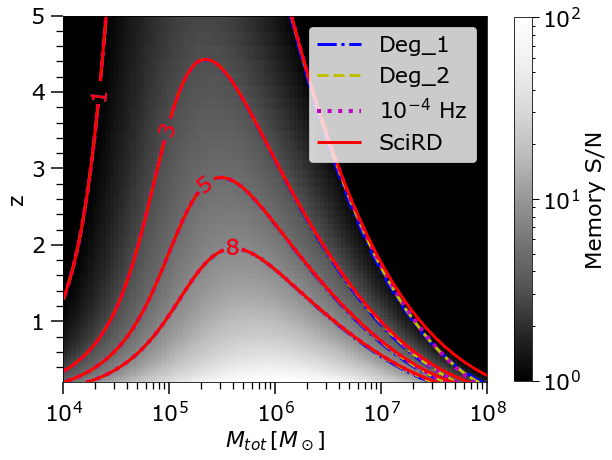

In [17]:
fig, ax = plt.subplots(figsize=(9.5,6.75))

ax.set_xscale('log')
ax.set_yscale('linear')
ax.minorticks_on()
ax.tick_params('both', length=12, width=1.5, which='major', pad=6)
ax.tick_params('both', length=7, width=1.3, which='minor', pad=6)
ax.set_xlabel(r"$M_{tot} \, [M_\odot]$", fontsize=22)
ax.set_ylabel("z", fontsize=22)
ax.set_ylim(0.2,5)

Dens = ax.pcolormesh(Mtot_gridLISA, z_gridLISA, np.sqrt(SNR2sdistLISA_deg0_high+SNR2sdistLISA_deg0_low), 
                     cmap='Greys_r', norm=LogNorm(vmin=1.,vmax=100.))
Cont1 = ax.contour(Mtot_gridLISA, z_gridLISA, np.sqrt(SNR2sdistLISA_deg1_high+SNR2sdistLISA_deg1_low), 
                  colors='b',linestyles='dashdot',linewidths=3,levels=(1,3,5,8))
Cont2 = ax.contour(Mtot_gridLISA, z_gridLISA, np.sqrt(SNR2sdistLISA_deg2_high+SNR2sdistLISA_deg2_low), 
                  colors='y',linestyles='dashed',linewidths=3,levels=(1,3,5,8))
Cont1em4 = ax.contour(Mtot_gridLISA, z_gridLISA, np.sqrt(SNR2sdistLISA_deg0_high), 
                  colors='m',linestyles='dotted',linewidths=4,levels=(1,3,5,8))
Cont = ax.contour(Mtot_gridLISA, z_gridLISA, np.sqrt(SNR2sdistLISA_deg0_high+SNR2sdistLISA_deg0_low), 
                  colors='r',linewidths=3,levels=(1,3,5,8))
ax.clabel(Cont1,fmt='%1.0f',manual=[(2e4,4),(1e5,3.5),(2e5,2.9),(4e5,1.8)])
ax.clabel(Cont2,fmt='%1.0f',manual=[(2e4,4),(1e5,3.5),(2e5,2.9),(4e5,1.8)])
ax.clabel(Cont1em4,fmt='%1.0f',manual=[(2e4,4),(1e5,3.5),(2e5,2.9),(4e5,1.8)])
ax.clabel(Cont,fmt='%1.0f',manual=[(2e4,4),(1e5,3.5),(2e5,2.9),(4e5,1.8)])
fig.colorbar(Dens, orientation='vertical', shrink=0.99, label='Memory S/N')

Cont.collections[0].set_label("SciRD")
Cont1.collections[0].set_label("Deg_1")
Cont2.collections[0].set_label("Deg_2")
Cont1em4.collections[0].set_label(r"$10^{-4}$ Hz")

ax.legend(loc='upper right')
# plt.savefig('SNRmemLISAz.pdf',bbox_inches='tight') # Uncomment to save figure
plt.show()